In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import shap
shap.initjs()

In [2]:

#Train
raw_data = pd.read_csv(open(r'\单台震中距预测\时间窗\0.1s\XGBoost\15个训练特征.csv',encoding='UTF-8'))
X_train = raw_data.iloc[:, 0:15].values
y_train = raw_data.iloc[:, 15].values    #导入数据  iloc通过行号获取行数据
#print("X",X)
#print("y",y)
#print("X",len(X))  

#Test
raw_data1 = pd.read_csv(open(r'\单台震中距预测\时间窗\0.1s\XGBoost\15个测试特征.csv',encoding='UTF-8'))
X_test = raw_data1.iloc[:, 0:15].values
y_test = raw_data1.iloc[:, 15].values    #导入数据  iloc通过行号获取行数据


In [4]:
#网格搜索最佳参数
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(xgb.XGBRegressor(),\
                    param_grid={"n_estimators":np.arange(100,1000,100),\
                                "max_depth": np.arange(3,10,1),\
                                "learning_rate":np.arange(0.01,0.1,0.01),\
                                "subsample":np.arange(0.5,1,0.1),\
                                
                               })
#"learning_rate":0.001-0.9
#"min_samples_leaf":[1,3,5,7,9]
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
     % (grid.best_params_, grid.best_score_))

The best parameters are {'learning_rate': 0.02, 'max_depth': 8, 'n_estimators': 900, 'subsample': 0.6} with a score of 0.61


In [3]:
from sklearn.model_selection import cross_val_score  # 交叉检验
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  # 批量导入指标算法
n_folds = 6  # 设置交叉检验的次数
cv_score_list = []  # 交叉检验结果列表
model_names = ['XGB']  # 不同模型的名称列表

# 定义模型参数进行训练

#模型训练
model_xgb = xgb.XGBRegressor(
    n_estimators=900,
    learning_rate=0.02,
    subsample=0.6,
    max_depth=8,
    reg_alpha=0,
    reg_lambda=1
#    gamma=9,
)
scores = cross_val_score(model_xgb, X_train, y_train, cv=n_folds)  # 将每个回归模型导入交叉检验模型中做训练检验
cv_score_list.append(scores)  # 将交叉检验结果存入结果列表

model_xgb.fit(X_train, y_train)

train_prediction=model_xgb.predict(X_train)
print(model_xgb)

# 模型效果指标评估
n_samples, n_features = X_train.shape  # 总样本量506,总特征数13
#print(n_samples, n_features)
model_metrics_name = [explained_variance_score, mean_absolute_error, mean_squared_error, r2_score]  # 回归评估指标对象集
model_metrics_list = []  # 回归评估指标列表
for i in range(1):  # 循环每个模型索引
    tmp_list = []  # 每个内循环的临时结果列表
    for m in model_metrics_name:  # 循环每个指标对象
        tmp_score = m(y_train, train_prediction)  # 计算每个回归指标结果
        tmp_list.append(tmp_score)  # 将结果存入每个内循环的临时结果列表
    model_metrics_list.append(tmp_list)  # 将结果存入回归评估指标列表
df1 = pd.DataFrame(cv_score_list, index=model_names)  # 建立交叉检验的数据框
df2 = pd.DataFrame(model_metrics_list, index=model_names, columns=['ev', 'mae', 'mse', 'r2'])  # 建立回归指标的数据框
print ('samples: %d \t features: %d' % (n_samples, n_features))  # 打印输出样本量和特征数量
print (70 * '-')  # 打印分隔线
print ('cross validation result:')  # 打印输出标题
print (df1)  # 打印输出交叉检验的数据框
print (70 * '-')  # 打印分隔线
print ('regression metrics:')  # 打印输出标题
print (df2)  # 打印输出回归指标的数据框
print (70 * '-')  # 打印分隔线
print ('short name \t full name')  # 打印输出缩写和全名标题
print ('ev \t explained_variance')
print ('mae \t mean_absolute_error')
print ('mse \t mean_squared_error')
print ('r2 \t r2')
print (70 * '-')  # 打印分隔线


print("训练标准差=",np.std(y_train-train_prediction))
print("训练误差均值=",np.mean(y_train-train_prediction))
print("训练平均绝对误差=",np.mean(abs(y_train-train_prediction)))

#测试
test_prediction=model_xgb.predict(X_test)

from sklearn import metrics
from sklearn.metrics import r2_score
print(len(y_test-test_prediction))
print("测试标准差=",np.std(y_test-test_prediction))
print("测试误差均值=",np.mean(y_test-test_prediction))
print("测试平均绝对误差=",np.mean(abs(y_test-test_prediction)))

print("测试平均绝对误差MAE=",metrics.mean_absolute_error(test_prediction, y_test))
print("测试RMSE=",metrics.mean_squared_error(test_prediction, y_test)**0.5)
print("测试r2 score:", r2_score(y_test, test_prediction))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=900, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
samples: 13353 	 features: 15
----------------------------------------------------------------------
cross validation result:
            0        1         2         3         4         5
XGB  0.640996  0.54231  0.592741  0.345869  0.479353  0.600431
----------

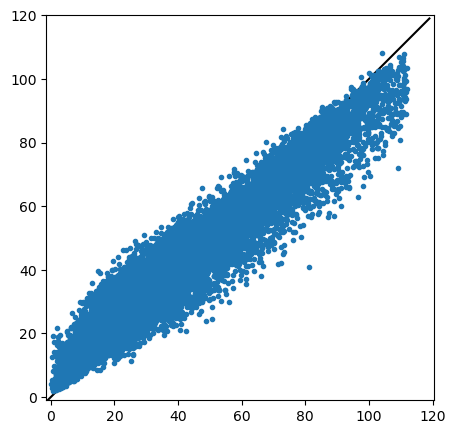

In [4]:
#训练结果
plt.figure(figsize=(5, 5))
plt.axis('equal')
#y_train-pre_y_list[3]
x3 = np.arange(-1, 120, 1)
y3=x3
plt.plot(x3, y3, "black")

plt.plot(y_train,train_prediction,'.')
plt.xlim(-1, 120)
plt.ylim(-1, 120)
plt.show()

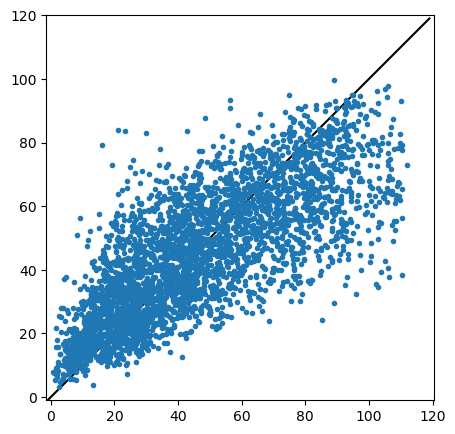

测试r2 score: 0.5857747574179555
测试平均绝对误差= 12.556182866897547


In [6]:
#测试结果
plt.figure(figsize=(5, 5))
plt.axis('equal')
#y_test-data
x3 = np.arange(-1, 120, 1)
y3=x3
plt.plot(x3, y3, "black")

plt.plot(y_test,test_prediction,'.')
plt.xlim(-1, 120)
plt.ylim(-1, 120)
plt.show()

from sklearn.metrics import r2_score
print("测试r2 score:", r2_score(y_test, test_prediction))  #16.38  0.58
print("测试平均绝对误差=",np.mean(abs(y_test-test_prediction)))